In [32]:
import sys
sys.path.append("..")
import jsq_ps.models as jsq
import numpy as np
import matplotlib.pyplot as plt
import ciw
import scipy
import pandas as pd
plt.style.use('seaborn-v0_8-whitegrid')

In [33]:
times = np.linspace(0, 6, 200)
lambda_ = 10
R = 2
rho = 0.85
mu = lambda_/(R * rho)
limit = 30
infty = 130

In [34]:
B = jsq.MethodB(lambda_=lambda_, mu=mu, R=R, limit=limit, infty=infty, times=times)

In [35]:
percentile_99 = B.times[[i for i, p in enumerate(B.sojourn_time_cdf) if p > 0.99][0]]
percentile_99

4.251256281407035

In [36]:
class ErrorTracker(ciw.trackers.StateTracker):
    def initialise(self, simulation):
        """
        Initialises the state tracker class.
        """
        self.simulation = simulation
        self.observations = []
        self.state = 0.0
        self.history = [[self.simulation.current_time, self.hash_state()]]
        
    def change_state_release(self, node, destination, ind, blocked):
        if (ind.data_records[-1].arrival_date > 250) and (node.id_number != 1):
            self.observations.append(ind.data_records[-1].service_time)
        self.state = np.nanpercentile(self.observations, 99)

    def hash_state(self):
        """
        Returns a hashable state.
        """
        return self.state

In [37]:
S = jsq.Simulation(lambda_=lambda_, mu=mu, R=R, max_time=7500, warmup=250, times=times, tracker=ErrorTracker())

  0%|                                                | 0/7500 [00:00<?, ?it/s]/Users/geraintpalmer/Documents/Research/mmr-jsq-ps/jsq_env/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  7%|█▌                     | 527.9043301009432/7500 [00:02<01:05, 106.39it/s]

KeyboardInterrupt: 

  7%|█▋                     | 534.6823134822887/7500 [00:15<01:05, 106.39it/s]

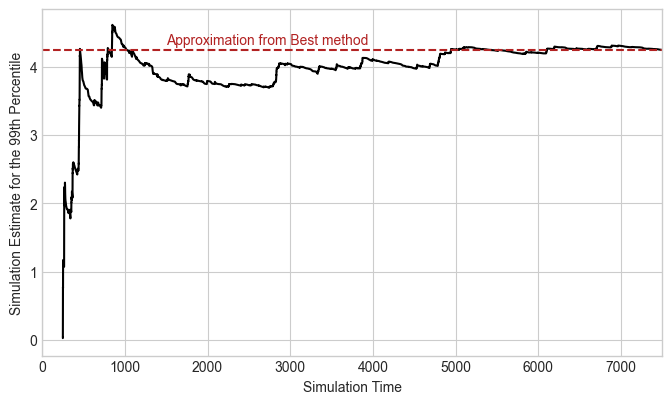

In [31]:
fig, ax = plt.subplots(1, figsize=(8, 4.5))
ax.plot(
    [ts[0] for ts in S.Q.statetracker.history],
    [ts[1] for ts in S.Q.statetracker.history],
    c='black',
)
ax.plot([0, S.max_time], [percentile_99, percentile_99], linestyle='dashed', c='firebrick')
ax.text(1500, percentile_99 * 1.02, "Approximation from Best method", c='firebrick')
ax.set_xlim(0, 7500)
ax.set_xlabel("Simulation Time")
ax.set_ylabel("Simulation Estimate for the 99th Percentile")
fig.savefig("simulation-runtime-demo.pdf")